<Axes: >

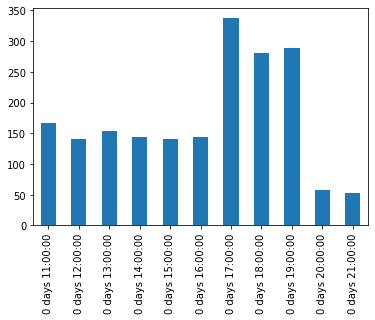

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Vstupní data
data = np.empty((30, 11), dtype=int)
for day in range(30):
    for hour in range(11):
        if hour <= 5:
            data[day][hour] = int(np.random.normal(150, 20))
        elif 5 < hour <= 8:
            data[day][hour] = int(np.random.normal(300, 30))
        else:
            data[day][hour] = int(np.random.normal(50, 5))

# Vizualizace dat
idx = pd.timedelta_range(start='11:00:00', end='21:00:00', freq='H')
ts = pd.Series(data[12], index=idx)
plt.figure()
ts.plot(kind='bar')

In [ ]:
# Simulace
from simpy import *

env = Environment()

num_cashiers = 3
num_ushers = 2
num_servers = 3

cashier = Resource(env, capacity=num_cashiers)
usher = Resource(env, capacity=num_ushers)
server = Resource(env, capacity=num_servers)

